In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import seaborn as sns
import datetime 
import scipy.stats as st
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import VotingRegressor

import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMRegressor

In [2]:
df = pd.read_csv('/kaggle/input/realestatepriceprediction/train.csv')
y_train = df['Price']
X_train = df.drop('Price', axis=1)

X_test = pd.read_csv('/kaggle/input/realestatepriceprediction/test.csv')

preds_final = pd.DataFrame()
preds_final['Id'] = X_test['Id'].copy()

print('строк в трейне ', X_train.shape[0])
print('строк в тесте ', X_test.shape[0])

строк в трейне  10000
строк в тесте  5000


In [3]:
X_train['DistrictId'] = X_train['DistrictId'].astype(str)
X_test['DistrictId'] = X_test['DistrictId'].astype(str)

X_train.set_index('Id', inplace=True)
X_test.set_index('Id', inplace=True)

In [4]:
class DataClean:
    
    def __init__(self):
        self.medians = None
        self.means = None
        self.quantile_999 = None
        self.std = None
        self.districtIdYearMedain = None
        self.KitchenSquareMedian = None
        self.lr_lifesquare_square = None
        self.lr_Kitchensquare_square = None
        self.HealtCare_1_median_by_districtId = None
        self.SquareDownBound = None
        self.SquareUpBound = None
        self.SquareCleaningCondition = None
        
    def fit(self, X):
        self.medians = X.median()
        self.mean = X.mean()
        self.quantile_999 = X.quantile(q=0.999)
        self.std = X.std()
        self.house_year_group_by_distId_medians = dict(X.groupby('DistrictId')['HouseYear'].median())
        self.HealtCare_1_median_by_districtId = dict(X.groupby('DistrictId')['Healthcare_1'].median())
        
        self.SquareUpBound = 200
        self.SquareDownBound = 20
        
        self.SquareCleaningCondition = (X['Square'] < self.SquareDownBound) | ((X['Square'] > self.SquareUpBound) & (X['Square'] > (self.medians['Square']/self.medians['Rooms'])*X['Rooms'] + 2*self.std['Square']))
        
        # изпользую линейную регрессию для заполнения пропусков и выбросов в KithcenSquare и LifeSquare
        self.lr_Kitchensquare_square = LinearRegression()
        self.lr_Kitchensquare_square.fit(np.array(X.loc[(~X['KitchenSquare'].isna()) & ~self.SquareCleaningCondition, 'Square']).reshape(-1, 1),
                                         X.loc[(~X['KitchenSquare'].isna()) & ~self.SquareCleaningCondition, 'KitchenSquare'])
          
        self.lr_lifesquare_square = LinearRegression()
        self.lr_lifesquare_square.fit(np.array(X.loc[(~X['LifeSquare'].isna()) & ~self.SquareCleaningCondition, 'Square']).reshape(-1, 1),
                                      X.loc[(~X['LifeSquare'].isna()) & ~self.SquareCleaningCondition, 'LifeSquare'])
        
         
    def transform(self, X, y=None):
        
        #Rooms
        X['Rooms_outlier'] = 0
        X.loc[((X['Rooms'] > 5) & (X['Square'] < ((self.medians['Square']/self.medians['Rooms'])*X['Rooms'] - 2*self.std['Square']))) | (X['Rooms'] == 0), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = np.ceil(X['Square']/(self.medians['Square']/self.medians['Rooms'] + 0.5*self.std['Square']))
        X.loc[(X['Rooms'] > 5) & (X['Square'] < ((self.medians['Square']/self.medians['Rooms'])*X['Rooms'] - 2*self.std['Square'])), 'Rooms'] = np.ceil(X['Square']/self.medians['Square']) 
        
        #Square
        down_bound = 36
        X['Square_outlier'] = 0
        
        condition = (X['Square'] < self.SquareDownBound) | ((X['Square'] > self.SquareUpBound) & (X['Square'] > (self.medians['Square']/self.medians['Rooms'])*X['Rooms'] + 2*self.std['Square']))
        
        X.loc[condition, 'Square_outlier'] = 1
        
        X.loc[X['Square'] < self.SquareDownBound, 'Square'] = (self.medians['Square']/self.medians['Rooms'])*X['Rooms']
        X.loc[(X['Square'] > self.SquareUpBound) & (X['Square'] > (self.medians['Square']/self.medians['Rooms'])*X['Rooms'] + 2*self.std['Square']), 'Square'] = (self.medians['Square']/self.medians['Rooms'])*X['Rooms'] 

       
        #HouseFloor, Floor
        X['Floor_outlier'] = 0
        X.loc[X['Floor'] > self.quantile_999['Floor'], 'Floor_outlier'] = 1
        
        X.loc[X['Floor'] > self.quantile_999['Floor'], 'Floor'] = self.quantile_999['Floor']
        
        X['HouseFloor_outlier'] = 0
        X.loc[(X['HouseFloor'] < X['Floor']) | (X['HouseFloor'] > self.quantile_999['HouseFloor']), 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] > self.quantile_999['HouseFloor'], 'HouseFloor'] = self.quantile_999['HouseFloor']
        X.loc[X['HouseFloor'] < X['Floor'], 'HouseFloor'] = X['Floor']
        
        #HouseYear
        current_year = datetime.datetime.now().year
        
        X['HouseYear_outline'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outline'] = 1
        
        df = X.copy() 
        df['HouseYearDist_median'] = df['DistrictId'].map(self.house_year_group_by_distId_medians)
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = df['HouseYearDist_median']
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        del df
        
        #Social_2
        if 'Social_2' in X.columns:
            X.drop('Social_2', axis=1, inplace=True)
            
        # Healthcare_1
        X['Healthcare_1_outlier'] = 0
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1_outlier'] = 1
        
        df = X.copy()
        df['Healthcare_1_median'] = df['DistrictId'].map(self.HealtCare_1_median_by_districtId)
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = df['Healthcare_1_median']

        del df
        
        #if 'Healthcare_1' in X.columns:
        #    X.drop('Healthcare_1', axis=1, inplace=True)
            
        #LifeSqure
        X['LifeSquare_outlier'] = 0
        X.loc[X['LifeSquare'].isna(), 'LifeSquare_outlier'] = 1
        condition = ((X['LifeSquare'] - 0.5*self.std['LifeSquare']) > X['Square']) | (X['LifeSquare'] < 7.5)
        X.loc[condition, 'LifeSquare_outlier'] = 1
        
        X.loc[condition, 'LifeSquare'] = np.nan
        
        LifeSquare_sample = self.lr_lifesquare_square.predict(np.array(X.loc[X['LifeSquare'].isna(), 'Square']).reshape(-1, 1))
        X.loc[X['LifeSquare'].isna(), 'LifeSquare'] = LifeSquare_sample
        
        #KitchenSquare
        X['KitchenSquare_outlier'] = 0
        condition = (abs(1 - X['KitchenSquare']/X['Square']) < 0.5) | (X['KitchenSquare'] > X['Square']) | (X['KitchenSquare'] < 3)
        X.loc[condition, 'KitchenSquare_outlier'] = 1
        X.loc[condition, 'KitchenSquare'] = np.nan
        
        KitchenSquare_sample = self.lr_Kitchensquare_square.predict(np.array(X.loc[X['KitchenSquare'].isna(), 'Square']).reshape(-1, 1))
        X.loc[X['KitchenSquare'].isna(), 'KitchenSquare'] = KitchenSquare_sample

        
        return X

In [5]:
clean = DataClean()
clean.fit(X_train)

X_train = clean.transform(X_train)
X_test = clean.transform(X_test)

In [6]:
X_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_1,Shops_2,Rooms_outlier,Square_outlier,Floor_outlier,HouseFloor_outlier,HouseYear_outline,Healthcare_1_outlier,LifeSquare_outlier,KitchenSquare_outlier
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.000000,7.0,9.0,1969.0,0.089040,B,...,11,B,0,0,0,0,0,1,0,0
15053,41,3.0,65.683640,40.049543,8.000000,7.0,9.0,1978.0,0.000070,B,...,16,B,0,0,0,0,0,0,0,0
4765,53,2.0,44.947953,29.197612,6.154839,8.0,12.0,1968.0,0.049637,B,...,3,B,0,0,0,0,0,0,0,1
5809,58,2.0,53.352981,52.731512,9.000000,8.0,17.0,1977.0,0.437885,B,...,5,B,0,0,0,0,0,0,0,0
10783,99,1.0,39.649192,23.776169,7.000000,11.0,12.0,1976.0,0.012339,B,...,4,B,0,0,0,0,0,0,0,0


In [7]:
class FeatureGenetator():
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.med_price_square_by_district = None
        self.med_price_S1H2 = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  
        
        temp = pd.DataFrame(X.groupby(['Social_1', 'Helthcare_2'])['Square'].count())
        
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        df_2 = X.copy()
        df_3 = X.copy()
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict',
            #self.med_price_by_district = df.groupby(['DistrictId_popular'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict',
                                                                                                                                             'DistrictId_popular': 'DistrictId'})
            df_2['Price'] = y.values
            df_2['DistrictId_popular'] = df_2['DistrictId'].copy()
            df_2.loc[~df_2['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_square_by_district = df_2.groupby(['DistrictId_popular'], as_index=False).agg({'Square':'median', 'Price':'median'}).rename(columns={'Square':'MedSquareByDistrict',
            'Price':'MedPriceByDistrict_0', 'DistrictId_popular': 'DistrictId'})
            df_3['Price'] = y.values
            
            self.med_price_S1H2 = df_3.groupby(['Social_1', 'Helthcare_2'],  as_index=False).agg({'Price': 'median', 'Square':'count'}).rename(columns={'Price':'MedPriceByS1H2',
            'Square': 'Group_pop'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByFloorYear'})

            
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # ----------------------
        # Categorical features embeddings
        f1 = 'KitchenSquare';
        f2 = 'HouseYear';
        X['f2_cat'] = (X[f2] // 10 * 10).astype('category')

        # Feature embedding
        mapping = X.groupby('f2_cat')[f1].mean().to_dict()
        X['f1__mean__by_f2_cat'] = X['f2_cat'].map(mapping).astype('float64')

        # feature - feature_embedding
        X['diff_to_f1__mean__by_f2_cat'] = X[f1] - X['f1__mean__by_f2_cat']
        # ----------------------
        
        # Feature embedding
        mapping = X.groupby('DistrictId')['Shops_1'].mean().to_dict()
        X['Shops_1__mean__by_DistrictId'] = X['DistrictId'].map(mapping)
        
        # feature - feature_embedding
        X['diff_to_Shops_1__mean__by_DistrictId'] = X['Shops_1'] - X['Shops_1__mean__by_DistrictId'] 
        
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            #X = X.merge(self.med_price_by_district, on=['DistrictId'], how='left')
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            
        if self.med_price_square_by_district is not None:
            X = X.merge(self.med_price_square_by_district, on=['DistrictId'], how='left')
            X['med_price_1_square_meter_by_district'] = X['MedPriceByDistrict_0']/X['MedSquareByDistrict']
            X.drop(['MedPriceByDistrict_0', 'MedSquareByDistrict'], axis=1)
            
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X

In [8]:
features_builder = FeatureGenetator()
features_builder.fit(X_train, y_train)

X_train = features_builder.transform(X_train)
X_test = features_builder.transform(X_test)

In [9]:
X_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,diff_to_f1__mean__by_f2_cat,Shops_1__mean__by_DistrictId,diff_to_Shops_1__mean__by_DistrictId,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear,MedSquareByDistrict,MedPriceByDistrict_0,med_price_1_square_meter_by_district
0,35,2.0,47.981561,29.442751,6.000000,7.0,9.0,1969.0,0.089040,1,...,0.125585,11.000000,0.000000,3.0,3.0,NaN,178762.420993,NaN,NaN,NaN
1,41,3.0,65.683640,40.049543,8.000000,7.0,9.0,1978.0,0.000070,1,...,1.297001,2.597701,13.402299,3.0,3.0,300009.450063,178762.420993,47.936648,210694.850106,4395.277115
2,53,2.0,44.947953,29.197612,6.154839,8.0,12.0,1968.0,0.049637,1,...,0.280425,4.143678,-1.143678,3.0,3.0,263206.223152,178762.420993,54.333187,245978.794474,4527.229293
3,58,2.0,53.352981,52.731512,9.000000,8.0,17.0,1977.0,0.437885,1,...,2.297001,3.636872,1.363128,3.0,3.0,166809.665642,178762.420993,51.283320,151557.904767,2955.306014
4,99,1.0,39.649192,23.776169,7.000000,11.0,12.0,1976.0,0.012339,1,...,0.297001,5.731959,-1.731959,4.0,3.0,158539.052715,181462.733245,45.363892,178829.166450,3942.103724


In [10]:
ind = 0
if ind > 0:
    #District dummies
    Districts = set(np.concatenate((X_train['DistrictId'], X_test['DistrictId']), axis=0))

    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)

    Districts = ['DistrictId_' + x for x in Districts]

    def Districts_dummy_add(X):
        for x in Districts:
            if x not in X.columns:
                X[x] = 0
        return X

    Districts_dummy_add(X_train)
    Districts_dummy_add(X_test)

In [11]:
df_test = X_test.copy()
df_train = X_train.copy()

dist = [c for c in df_train.columns if c.startswith('Dist')]

In [12]:
cols = ['Square',
'HouseYear',
'LifeSquare',
#'MedPriceByDistrict',
'KitchenSquare',
'Healthcare_1',
'HouseFloor',
'Social_3',
'Ecology_1',
'med_price_1_square_meter_by_district',
#'MedPriceByFloorYear',
'Social_1',
'Floor',
'Shops_1',
#'LifeSquare_outlier',
#'new_district',
#'diff_to_Shops_1__mean__by_DistrictId',
'diff_to_f1__mean__by_f2_cat',
'Rooms',
#'KitchenSquare_outlier',
'Helthcare_2']

X_test = df_test[cols]
X_train = df_train[cols]

In [13]:
model = LGBMRegressor('gbdt',
                      max_depth=8,
                      #min_samples_leaf=10,
                      n_estimators=850,
                      learning_rate = 0.02,
                      random_state=42)

cv_score = cross_val_score(model, X_train, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
R2: 0.752 +- 0.015


In [14]:
model.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(learning_rate=0.02, max_depth=8, n_estimators=850,
              random_state=42)

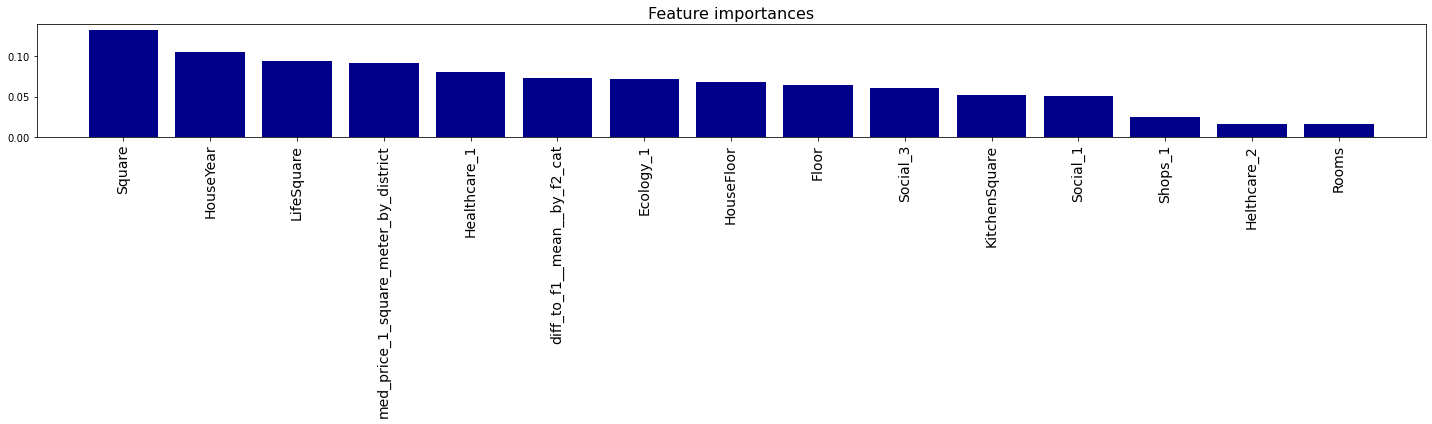

In [15]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X_train)

In [16]:
ind = 0
if ind > 0:
    parameters = [{
        'max_depth': np.arange(3, 10, 1),
        #'min_samples_leaf': np.arange(9, 12, 1),
        'n_estimators': np.arange(100, 1000, 50),
        'learning_rate': np.arange(0.01, 0.05, 0.01)
    }]

    clf = GridSearchCV(
        estimator=LGBMRegressor('gbdt', random_state=42),
        param_grid=parameters,
        scoring='r2',
        cv=4,
        n_jobs=-1,
        )
    
    clf.fit(X_train, y_train)
    clf.best_params_

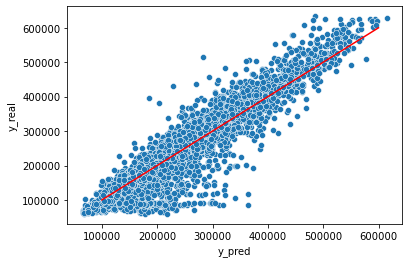

In [17]:
sns.scatterplot(model.predict(X_train), y_train)
plt.xlabel('y_pred')
plt.ylabel('y_real')
plt.plot([x for x in range(100000, 600000)], [x for x in range(100000 ,600000)], c='r')

In [18]:
y_pred_final = model.predict(X_test)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,150078.016457
1,15856,206191.145018
2,5480,239461.008797
3,15664,338050.603574
4,14275,144077.593742
